# Reality Mining


### Author:  Elsa Scola Martín

### Objectives:

-  find the correlation among people who frequently work in the same place or near around

### What is done in the Notebook: 

-  preprocess the dataset
-  preparing data for clustering
-  calculate the optimal number of clusters and compute k means
-  apply PCA (Principal Component Analysis)
-  analyze and contrast the results 

# Importing the libraries

First of all, I import all relevant libraries to be used in the notebook. 

In [1]:
# General Imports
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt

# To load the data
import scipy.io as sio

# To transform dates from matlab format to Python format
from datetime import datetime, timedelta

# To apply KMeans and PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Reading the dataset

In [2]:
# I load the data which is in matlab format, it takes less than a minute to load the data
mat_contents = sio.loadmat('C:/Users/elsas.DESKTOP-DVRVL8F/OneDrive/Escritorio/UNI/MLNN/Projects/Project1/Reality Mining/RealityMining/realitymining.mat')

In [3]:
# I print the keys of the dataset so I can see how is divided
mat_contents.keys()

dict_keys(['__header__', '__version__', '__globals__', 'network', 's'])

The actual collected data is located in network and s so we will focus on those two main parts. 
'network' contains the data collected on the online survey completed by 94 of the 106 Reality Mining subjects.
's' includes the subject data of 106 individuals.

In [4]:
# I assign each data section to a variable for convenience.
networkSurv=mat_contents['network'][0][0]
subjects=mat_contents['s'][0]


In [5]:
# I observe the structure of the survey data
networkSurv.dtype

dtype([('friends', 'O'), ('outlab', 'O'), ('lab', 'O'), ('sub_sort', 'O')])

The network survey data is divided in 4 parts:
- **'friends'**: 94 arrays (each one represents a subject of the survey) in which is represented if each person is part of the close circle of friends of the subject. '**1**' for Yes, '**nan**' for No.
- **'outlab'**: 94 arrays (each one represents a subject of the suvey) in which is represented the proximity (within 10 feet/3 metres) with eachperson outside the lab **5** *at least 4-8 hours per day* **4** *at least 2-4 hours per day*  **3** *at least 2 hrs - 30 minutes per day* **2** *at least 10 - 30 minutes per day* **1** *at least 5 minutes* **0(default)** *0-5 minutes*.
- **'lab'**: 94 arrays (each one represents a subject of the survey) in which is represented the proximity (within 10 feet/3 metres) with eachperson at work **5** *at least 4-8 hours per day* **4** *at least 2-4 hours per day*  **3** *at least 2 hrs - 30 minutes per day* **2** *at least 10 - 30 minutes per day* **1** *at least 5 minutes* **0(default)** *0-5 minutes*.
- **'sub_sort'**: an array of 94 numbers (each one represents the number/identifier of a subject of the survey).

I will focus on the **'lab'** and **'friends'** data as our project focuses on workplace relationships.

In [6]:
# I assign each data section to a variable for convenience.
friends=networkSurv['friends']
outlab=networkSurv['outlab']
lab=networkSurv['lab']
sub_sort=networkSurv['sub_sort'][0]

# Preprocessing and preparation of the data

I am interested only in the subjects that completed the survey so in the end I can compare my results to the survey without having missing data.

In [7]:
# This is the array that contains the subjects that completed the survey
sub_sort

array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  19,  20,  21,  22,  23,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  35,  36,  37,  38,  40,  41,  42,  43,  44,  46,
        48,  49,  50,  52,  53,  54,  55,  56,  57,  58,  60,  61,  62,
        63,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 106, 107], dtype=uint8)

Now, I store on a list the identifiers of the towers associated to the workplace (see [RealityMining_ReadMe](http://realitycommons.media.mit.edu/download.php?file=RealityMiningReadMe.pdf) document).

In [8]:
towers = [5119.40811,5119.40332,5123.40763,5119.40801,5119.40802,
          5131.43861,5119.40793,24127.132,24127.131,24127.2421,
          24127.2353,24127.111,24127.2832,24127.113,24127.2422,
         24127.112,24127.2413,24127.133,24127.2433,24123.261,24127.2832,5119.40342,24127.2833,24127.182]
len(towers)

24

subjects[ i ][ 'locs' ] contains all the connections to towers of subject i and the date of that connection. 

The next function loops through all the connections to towers registered in each subject and stores in a list the subjects that have been at list once near the towers associated to the workplace (as I am only interested in subjects that have ever been in the workplace). 



In [9]:
def finalSubjFunct():
    s=0
    finalSubj=[]
    length=len(sub_sort)-2
    surv=0
    while surv<length:
        s=sub_sort[surv]
        i=0
        flag=0
        if len(subjects[s]['locs'])>0:
            if len(subjects[s]['locs'][0])>0:
                while i<len(subjects[s]['locs']) and flag==0:
                    #print(s)
                    #print(i)
                    for j in range(len(towers)):
                         if subjects[s]['locs'][i][1]==towers[j]:
                                flag=1
                                finalSubj.append(s)
                    i+=1            
        surv+=1
    return finalSubj

In [10]:
# I store in final the final list of subjects, this function takes less than a minute to run
final=finalSubjFunct()

In [11]:
len(final) #there are 63 subjects

63

As I will need to compute the time difference between tower connections (to know how much time has been each subject on a specific location in the workplace), I have to convert the dates from matlab format to Python format, so then I can compute the difference.

In [12]:

# I create a function that converts the date from a matlab format to the Python format
def convertDatetime(dt):
    return datetime.fromordinal(int(dt)) + timedelta(days=dt%1) - timedelta(days=366) - timedelta(hours=5) 



# I create a function that given 2 dates returns 
#  -the difference in days 
#  -the difference in hours (the difference is made only between the 2 hours, it does not take into account the dates) 
def funcDaysHoursDif(time1, time2):
    #find the difference between two dates
    diff = time2 - time1

    days = diff.days  
    hours = (diff.seconds) / 3600  

    return(days, hours)



Now I create a function that generates empty matrices (this will be the input of the funcStructData funtion).

In [13]:
def genEmptyMatrix(rows,columns):
    table=[]
    for r in range(rows):
        row=[]
        for c in range(columns):
            row.append(0)
        table.append(row)
    return table
        

The next function given an empty matrix and a threshold returns in that same matrix the next data:
-  each row represents a subject (of the previously selected ones)
-  from column 0 to 23 it is represented the time spent in each of the 24 towers that represent the workplace
-  from column 24 to 47 it is represented the number of times a subject has been detected from each of the 24 towers that represent the workplace 


Note: I only add time to the time spent in a tower and 1 to the frequency of that tower if the time spent in that tower is greater than the threshold. I do this because if the time spent is less than the threshold we consider that the subject has not been working in that place.

In [14]:
# This function takes less than 2 minutes to run
def funcStructData(emptyTable,threshold):
    table=emptyTable
    isWorkTower=0 #flag
    prevTime=convertDatetime(732198.52855324)
    days=0
    hours=0.0
    towerNum=0
    actTime=convertDatetime(732198.52855324)
    for f in range(len(final)):
        s=final[f]
        for i in range(len(subjects[s]['locs'])):
            if isWorkTower==1:
                actTime=convertDatetime(subjects[s]['locs'][i][0])
                days,hours=funcDaysHoursDif(prevTime,actTime)
                if days==0 and 10>=hours>=threshold:
                    table[f][towerNum]+=hours
                    table[f][towerNum+24]+=1
            t=0
            found=0
            while t<len(towers) and found==0:
                if subjects[s]['locs'][i][1]==towers[t]:
                    isWorkTower=1
                    prevTime=actTime
                    towerNum=t
                    found=1
                else:
                    isWorkTower=0
                t+=1
    return table
            
        

In [15]:
EmpTable=genEmptyMatrix(63,48)
dataTable=funcStructData(EmpTable,1)

Now I want to insert our final data structured on a .csv file, for that I use DataFrame from pandas.

In [16]:
data=dataTable
index=final
columns=['T0','T1','T2','T3','T4','T5','T6','T7','T8','T9','T10','T11','T12','T13','T14','T15','T16','T17','T18','T19'
         ,'T20','T21','T22','T23','F0','F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','F15'
         ,'F16','F17','F18','F19','F20','F21','F22','F23']
df = pd.DataFrame(data,index,columns)


When I visualize the data I notice that there are several towers that no subject has connected to, therefore, as they do not add any value, I don't take them into account. These towers are 7-20, 22 and 23, so I delete their corresponding times and frequencies.

In [17]:
modifiedDF = df.drop(['T7','T8','T9','T10','T11','T12','T13','T14','T15','T16','T17','T18','T19'
         ,'T20','T22','T23','F7','F8','F9','F10','F11','F12','F13','F14','F15'
         ,'F16','F17','F18','F19','F20','F22','F23'], axis=1)
modifiedDF.to_csv('datafile.csv')

# Clustering and visualization 

As I will be using the k-means algorithm to solve the problem and I need to specify a number (k) of clusters, I use the **elbow method** to determine the optimal number of clusters.

In [18]:
# I load the data from the file created above
dataframe = pd.read_csv("datafile.csv")
X = np.array(dataframe[['T0','T1','T2','T3','T4','T5','T6','T21',
                        'F0','F1','F2','F3','F4','F5','F6','F21']])

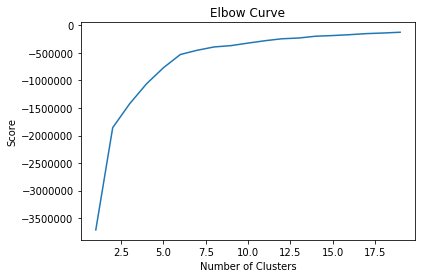

In [19]:
# I evaluate the elbow curve to know the optimal number of clusters
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

It can observed that the optimal value on the "elbow" is 6. This number is the same that was obtained on a study by their optimization process on the "Reality Mining" dataset: [K-means based clustering on mobile usage for social network analysis purpose](https://www.researchgate.net/publication/224219112_K-means_based_clustering_on_mobile_usage_for_social_network_analysis_purpose), this ensures that this really is the optimal value.

### K means

Now, I apply k-means to our data with the number of clusters obtained above and I fit it.

In [20]:
kmeans = KMeans(n_clusters=6)  
kmeans.fit(X) 


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Now I have the centroids of the clusters:

In [21]:
centroids=kmeans.cluster_centers_  
print(centroids)

[[ 6.89917460e+01  5.67995635e+01  2.06290079e+01  2.41595635e+01
   4.07836905e+01  7.34321429e+00  4.01376984e+00  2.56712500e+02
   2.80000000e+01  2.60000000e+01  7.85714286e+00  7.57142857e+00
   1.40000000e+01  1.71428571e+00  1.71428571e+00  8.42857143e+01]
 [ 2.96501190e+01  3.53546329e+01  1.20128770e+01  1.71483135e+00
   5.38283730e-01  7.10049603e-01  1.98112103e+00  1.09162996e+01
   1.32500000e+01  1.09285714e+01  4.35714286e+00  6.42857143e-01
   2.14285714e-01  1.78571429e-01  7.14285714e-01  3.85714286e+00]
 [ 2.00542415e+02  7.72217735e+01  2.83154701e+01  1.45850214e+01
   9.78309829e+00  1.05897436e+00  6.21049145e+00  2.41289530e+01
   7.90000000e+01  2.46923077e+01  9.00000000e+00  3.92307692e+00
   3.07692308e+00  5.38461538e-01  2.23076923e+00  7.38461538e+00]
 [ 1.12484306e+02  7.00090625e+01  4.17293056e+01  7.12993056e+00
   3.21736111e+00  1.82743056e-01  1.17219444e+01  5.13312986e+02
   4.57500000e+01  2.68750000e+01  1.25000000e+01  2.00000000e+00
   1.12

### PCA

As the results I have obtained are multidimensional, I cannot visualize them, for this it is convenient to use the Principal Component Analysis procedure to reduce it without losing coherence in our data. 
Therefore, I create a function that computes the PCA:

In [22]:
def doPCA(data):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca.fit(data)

    return pca

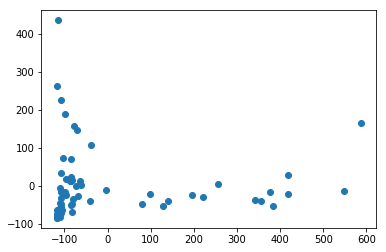

In [23]:
# I call the function
pca=doPCA(X)
# I apply the PCA that I have created to our data X
reduced_data = pca.transform(X)
# I show the reduced data
plt.scatter(reduced_data[:,0], reduced_data[:,1])

In [24]:
# I apply the same PCA to the previous centroids
centroidsPCA=pca.transform(centroids)

In [25]:
# I print the previous and the transformed shape to see the difference

print("original shape:   ", X.shape)
print("transformed shape:", reduced_data.shape)

original shape:    (63, 16)
transformed shape: (63, 2)


Now, I have the new clusters and centroids:

In [26]:
new_clusters = kmeans.predict(X)
centers = centroidsPCA
print(new_clusters)
print(centers)

[4 2 2 2 1 3 1 4 1 1 3 2 2 1 1 2 2 3 1 0 3 0 1 1 0 3 2 0 4 1 1 2 3 3 5 2 1
 1 5 2 1 1 4 1 1 1 2 0 0 1 0 2 1 1 1 1 5 1 1 1 1 3 1]
[[ 159.59253016  -30.68965975]
 [-103.3158842   -53.76637373]
 [ -74.06085292   16.88102531]
 [ 428.75060226    1.01478243]
 [-109.76141702  278.69273993]
 [ -84.15700519  125.98117818]]


### Visualize the data

We define a function that given a subject index returns the tower in which has spent most of his/her time.

In [27]:
def mostFreqTower(sIndex):
    subject=final[sIndex]
    i=0 
    max=0
    maxTower=0
    while i<=7:
        if X[sIndex][i]>max:
            max=X[sIndex][i]
            maxTower=i
        i+=1
    return maxTower
        

We now visualize the subjects in clusters with their most frequent tower:

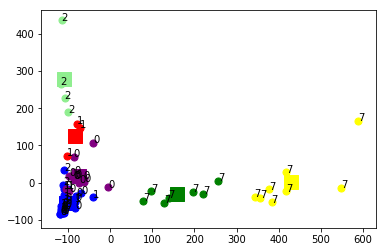

In [28]:
for index in range(len(reduced_data)):
    if new_clusters[index]==0:
        plt.scatter(reduced_data[index, 0], reduced_data[index, 1], s =50, c='g')
    if new_clusters[index]==1:
        plt.scatter(reduced_data[index, 0], reduced_data[index, 1], s =50, c='blue')
    if new_clusters[index]==2:
        plt.scatter(reduced_data[index, 0], reduced_data[index, 1], s =50, c='purple')
    if new_clusters[index]==3:
        plt.scatter(reduced_data[index, 0], reduced_data[index, 1], s =50, c='yellow')
    if new_clusters[index]==4:
        plt.scatter(reduced_data[index, 0], reduced_data[index, 1], s =50, c='lightgreen')
    if new_clusters[index]==5:
        plt.scatter(reduced_data[index, 0], reduced_data[index, 1], s =50, c='red')
    text=mostFreqTower(index)
    plt.annotate(text,(reduced_data[index, 0], reduced_data[index, 1]))
plt.scatter(centers[0,0],centers[0,1], s=200, c='g', marker='s')
plt.scatter(centers[1,0],centers[1,1], s=200, c='blue', marker='s')
plt.scatter(centers[2,0],centers[2,1], s=200, c='purple', marker='s')
plt.scatter(centers[3,0],centers[3,1], s=200, c='yellow', marker='s')
plt.scatter(centers[4,0],centers[4,1], s=200, c='lightgreen', marker='s')
plt.scatter(centers[5,0],centers[5,1], s=200, c='red', marker='s')

plt.show()

It can be observed that there is a correlation between the clusters and the most frequent tower for each subject.

Now, the same data is visualized but with the subject ID.

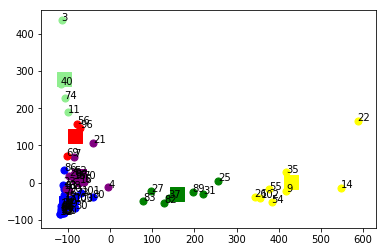

In [29]:
for index in range(len(reduced_data)):
    if new_clusters[index]==0:
        plt.scatter(reduced_data[index, 0], reduced_data[index, 1], s =50, c='g')
    if new_clusters[index]==1:
        plt.scatter(reduced_data[index, 0], reduced_data[index, 1], s =50, c='blue')
    if new_clusters[index]==2:
        plt.scatter(reduced_data[index, 0], reduced_data[index, 1], s =50, c='purple')
    if new_clusters[index]==3:
        plt.scatter(reduced_data[index, 0], reduced_data[index, 1], s =50, c='yellow')
    if new_clusters[index]==4:
        plt.scatter(reduced_data[index, 0], reduced_data[index, 1], s =50, c='lightgreen')
    if new_clusters[index]==5:
        plt.scatter(reduced_data[index, 0], reduced_data[index, 1], s =50, c='red')
    text=final[index]
    plt.annotate(text,(reduced_data[index, 0], reduced_data[index, 1]))
plt.scatter(centers[0,0],centers[0,1], s=200, c='g', marker='s')
plt.scatter(centers[1,0],centers[1,1], s=200, c='blue', marker='s')
plt.scatter(centers[2,0],centers[2,1], s=200, c='purple', marker='s')
plt.scatter(centers[3,0],centers[3,1], s=200, c='yellow', marker='s')
plt.scatter(centers[4,0],centers[4,1], s=200, c='lightgreen', marker='s')
plt.scatter(centers[5,0],centers[5,1], s=200, c='red', marker='s')

plt.show()

# Analyze and contrast the results

Now my objective is to see if there is any correlation between the location results obtained and the answers of each subject to the **'lab'** and **'friends'** survey mentioned in the beginning. 

For this, I create a function 'groupSubjectInClusters' that groups the subjects in clusters in a matrix when given the clusters and the subjects. This matrix will be used as an input for the 'computeQuality' function, which returns the success rate (between 0 and 1), considering as a success when a subject was valued from another subject of the same cluster with a proximity between 3-5.

In [30]:
def groupSubjectInClusters(clusters,subjects):
    c=[[],[],[],[],[],[]]
    for i in range(len(clusters)):
        if clusters[i]==0:
            c[0].append(subjects[i])
        if clusters[i]==1:
            c[1].append(subjects[i])
        if clusters[i]==2:
            c[2].append(subjects[i])
        if clusters[i]==3:
            c[3].append(subjects[i])
        if clusters[i]==4:
            c[4].append(subjects[i])
        if clusters[i]==5:
            c[5].append(subjects[i])
    return(c)

In [31]:
c=groupSubjectInClusters(new_clusters,final)

In [32]:
def computeQuality(clusters):
    import math
    flag=0
    positionQ=0
    positionJ=0
    successCount=0
    successSubject=0
    successClusterMean=0
    globalSuccess=0
    for i in range(len(clusters)): #iterate through the clusters
        successClusterMean=0
        for j in range(len(clusters[i])): #iterate through the elements of the clusters
            successCount=0
            flag=0
            p=0
            #iterate through the elements of sub_sort to get the position of subject j in network.lab
            while p<len(sub_sort) and flag==0:
                if sub_sort[p]==clusters[i][j]:
                    flag=1
                    positionJ=p
                p+=1

            for q in range(len(clusters[i])): #iterate through the elements of the clusters (except j)
                if q!=j:
                    flag=0
                    p=0
                    #iterate through the elements of sub_sort to get the position of subject q in network.lab[j]
                    while p<len(sub_sort) and flag==0:
                        if sub_sort[p]==clusters[i][q]:
                            flag=1
                            positionQ=p
                        p+=1
                    #as we previously used 1h as a threshold, we will only admit proximity between 3-5
                    if lab[positionJ][positionQ]==3 or lab[positionJ][positionQ]==4 or lab[positionJ][positionQ]==5:  
                        successCount+=1
            #the success for a particular subject
            successSubject=successCount/(len(clusters[i])-1) 
            successClusterMean+=successSubject
        #the mean of the success in a cluster
        successClusterMean=successClusterMean/len(clusters[i])
        globalSuccess+=successClusterMean
    #the mean of the success of all the clusters
    globalSuccess=globalSuccess/len(clusters)
    return globalSuccess

In [33]:
result=computeQuality(c)

In [34]:
result

0.026751797585130913

The same is done for the  **'friends'** survey:

In [35]:
def computeFriendsCorr(clusters):
    import math
    flag=0
    positionQ=0
    positionJ=0
    successCount=0
    successSubject=0
    successClusterMean=0
    globalSuccess=0
    for i in range(len(clusters)): #iterate through the clusters
        successClusterMean=0
        for j in range(len(clusters[i])): #iterate through the elements of the clusters
            successCount=0
            flag=0
            p=0
            #iterate through the elements of sub_sort to get the position of subject j in network.lab
            while p<len(sub_sort) and flag==0:
                if sub_sort[p]==clusters[i][j]:
                    flag=1
                    positionJ=p
                p+=1

            for q in range(len(clusters[i])): #iterate through the elements of the clusters (except j)
                if q!=j:
                    flag=0
                    p=0
                    #iterate through the elements of sub_sort to get the position of subject q in network.lab[j]
                    while p<len(sub_sort) and flag==0:
                        if sub_sort[p]==clusters[i][q]:
                            flag=1
                            positionQ=p
                        p+=1
                    #as we previously used 1h as a threshold, we will only admit proximity between 3-5
                    if not math.isnan(friends[positionJ][positionQ]):  
                        successCount+=1
            #the success for a particular subject
            successSubject=successCount/(len(clusters[i])-1) 
            successClusterMean+=successSubject
        #the mean of the success in a cluster
        successClusterMean=successClusterMean/len(clusters[i])
        globalSuccess+=successClusterMean
    #the mean of the success of all the clusters
    globalSuccess=globalSuccess/len(clusters)
    return globalSuccess

In [36]:
result2=computeFriendsCorr(c)
print(result2)

0.00603717270383937


As it can be observed, the frequency and time spent in a tower is not a good indicator of the proximity and friendship (respectively) of subjects that work on the same area.